In [12]:
import pandas as pd
import numpy as np
from darts.timeseries import TimeSeries
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
# dark_palette = ['#3E4095','#9F3E4B','#4D9458','#5D4774','#ADAA27']
# light_palette = ['#A6ABE4','#E3A3A7','#B2D9B8','#C6B9CF','#D9D89F']

In [15]:
df = pd.read_excel('datos.xlsx')

In [16]:
def predecir_xgboost(df, serie, splits = 5, test_size = 12, gap = 0, iter = 1000, learn_rate = 0.1,depth=3):

    #drop de las otras series y de ventas por rubro
    temp = df[serie]
    df = df.loc[:, ~df.columns.str.startswith('ru_')]
    df = df.drop(columns=['v_total', 'v_super', 'v_retail', 'v_cowork'])
    df = df.drop(columns=['int_ret_sup','int_ret_cow','int_sup_cow','porc_retail','porc_super','porc_cowork'])
    
    df[serie] = temp

    #agrego lags de la serie
    for i in [1,2,3,4,5,6,7,8,9,10,11]:
        df[f'{serie}_lag{i}'] = df[serie].shift(periods=i)
    
    
    #backwards fill para los nulos que provocaron los lags, y los que haya de las otras variables
    df = df.bfill()

    #features de fecha
    df = df.set_index('mes')
    df = df.sort_index()

    tss = TimeSeriesSplit(n_splits=splits, test_size=test_size, gap=gap)
    
    #preparo el grafico para devolver del walk forward validation
    #fig_walkforward, axs = plt.subplots(tss.get_n_splits(), 1, figsize=(15, 5), sharex=True)
    
    fig, ax = plt.subplots(figsize=(2, 15))
    plt.grid(False)

    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        val = df.iloc[val_idx]
        ax0 = plt.subplot2grid((splits*4+2, 11), (fold*2, 0),rowspan=2,colspan=5)
        train[serie].plot(ax=ax0,
                                label='Training Set',
                                title=f'Data Train/Test Split Fold {fold}')
        ax0.title.set_size(6)
        val[serie].plot(ax=ax0,label='Val Set')
        ax0.axvline(val.index.min(), color='black', ls='--')
        ax0.set_xlim(df.index.min(),df.index.max())
        fold += 1
    
    fold = 0
    preds = []
    scores = []
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        val = df.iloc[val_idx]

        FEATURES = train[train.columns.difference([serie])].columns
        TARGET = serie

        X_train = train[FEATURES]
        y_train = train[TARGET]

        X_val = val[FEATURES]
        y_val = val[TARGET]
        
        reg = xgb.XGBRegressor(booster='gbtree',
                        n_estimators=iter,
                        objective='reg:squarederror',
                        max_depth=depth,
                        learning_rate=learn_rate,
                        verbosity=0
                        )
        
        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric=['rmse', 'mae', 'mape'],
            verbose=1000)

        y_pred = reg.predict(X_val)
        preds.append(y_pred)

        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append(score)

    preds =pd.DataFrame(preds).T

    ax1 = plt.subplot2grid((splits*4+2, 11), (0, 6),rowspan=splits*2,colspan=5)
    plot_importance(reg, height=0.9, ax=ax1)
    
    
    ax2 = plt.subplot2grid((splits*4+2, 11), (splits*2+1+1, 0),rowspan=splits,colspan=11)
    val['prediction'] = reg.predict(X_val)
    
    val[serie].plot(figsize=(15, 5), title=f'Serie {serie} - Predicciones vs Real',ax=ax2)
    val['prediction'].plot(ax=ax2)
    plt.legend(['Datos Reales','Prediccion'])

    print(f"Mean Squared Error (MSE): {mean_squared_error(y_val, y_pred):.2e}")
    print(f"Mean Absolute Error (MAE):{mean_absolute_error(y_val, y_pred):.2e}")
    print(f'Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_val, y_pred)):.2e}')
    
    ax3 = plt.subplot2grid((splits*4+2, 11), (splits*3+1+2, 0),rowspan=splits,colspan=11)

    ax3.plot(train[serie], color = 'black', alpha=0.4)
    ax3.plot(val[serie], color = 'red', alpha=0.8)
    ax3.plot(val['prediction'], color = 'blue', alpha=0.6)
    ax3.set_xlabel('Mes')
    ax3.set_ylabel('USD')
    ax3.set_title(f'Serie {serie} completa')
    ax3.title.set_size(10)
    ax3.grid(True, color='0.6', dashes=(5,2,1,2))

    fig.set_size_inches((15,20))
    plt.tight_layout()


    return fig

[0]	validation_0-rmse:5616717.49178	validation_0-mae:5338892.87738	validation_0-mape:inf	validation_1-rmse:4048465.75222	validation_1-mae:3780984.79167	validation_1-mape:0.65728
[499]	validation_0-rmse:1.36036	validation_0-mae:0.98322	validation_0-mape:inf	validation_1-rmse:2720213.97556	validation_1-mae:1580827.04167	validation_1-mape:0.26459
[0]	validation_0-rmse:5128606.66965	validation_0-mae:4887798.78561	validation_0-mape:inf	validation_1-rmse:2585454.26652	validation_1-mae:2165311.39583	validation_1-mape:0.50003
[499]	validation_0-rmse:0.97705	validation_0-mae:0.75766	validation_0-mape:inf	validation_1-rmse:1960886.50056	validation_1-mae:1474680.95833	validation_1-mape:0.60573
[0]	validation_0-rmse:4661210.61352	validation_0-mae:4351828.29097	validation_0-mape:inf	validation_1-rmse:2898955.14892	validation_1-mae:2832151.95833	validation_1-mape:0.74921
[499]	validation_0-rmse:1.11439	validation_0-mae:0.83877	validation_0-mape:inf	validation_1-rmse:1057445.05193	validation_1-mae:86

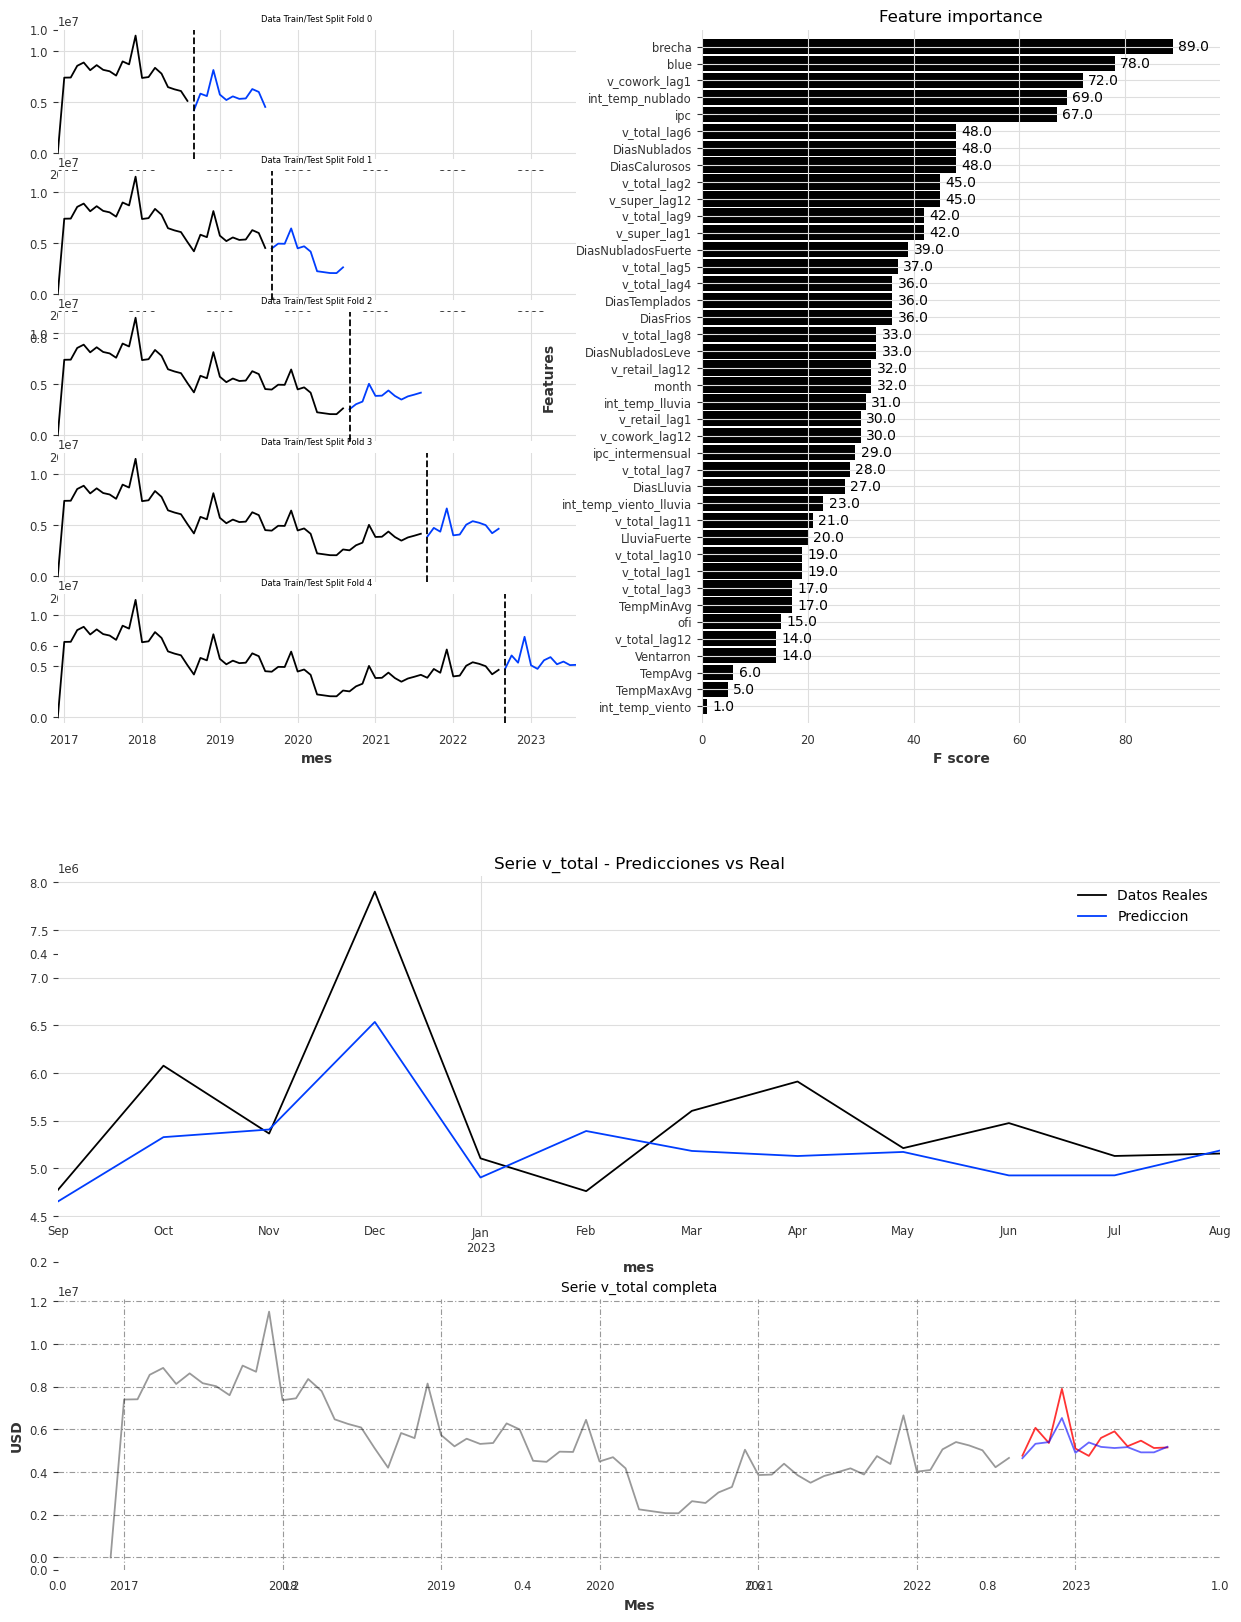

In [17]:
fig = predecir_xgboost(df,'v_total', iter = 500, learn_rate = 0.3, depth=2)

[0]	validation_0-rmse:2319615.29569	validation_0-mae:2215960.32976	validation_0-mape:inf	validation_1-rmse:1702095.60707	validation_1-mae:1627488.84896	validation_1-mape:0.67148
[499]	validation_0-rmse:0.48601	validation_0-mae:0.34630	validation_0-mape:inf	validation_1-rmse:990531.57235	validation_1-mae:711505.96875	validation_1-mape:0.29372
[0]	validation_0-rmse:2132304.87415	validation_0-mae:2019536.70227	validation_0-mape:inf	validation_1-rmse:1155126.49871	validation_1-mae:1088027.43750	validation_1-mape:0.54292
[499]	validation_0-rmse:0.41469	validation_0-mae:0.31243	validation_0-mape:inf	validation_1-rmse:435131.54192	validation_1-mae:364794.90625	validation_1-mape:0.20262
[0]	validation_0-rmse:1972531.76009	validation_0-mae:1855798.86778	validation_0-mape:inf	validation_1-rmse:1060584.36726	validation_1-mae:1048275.98438	validation_1-mape:0.65575
[499]	validation_0-rmse:0.52031	validation_0-mae:0.39912	validation_0-mape:inf	validation_1-rmse:268277.89552	validation_1-mae:199160.

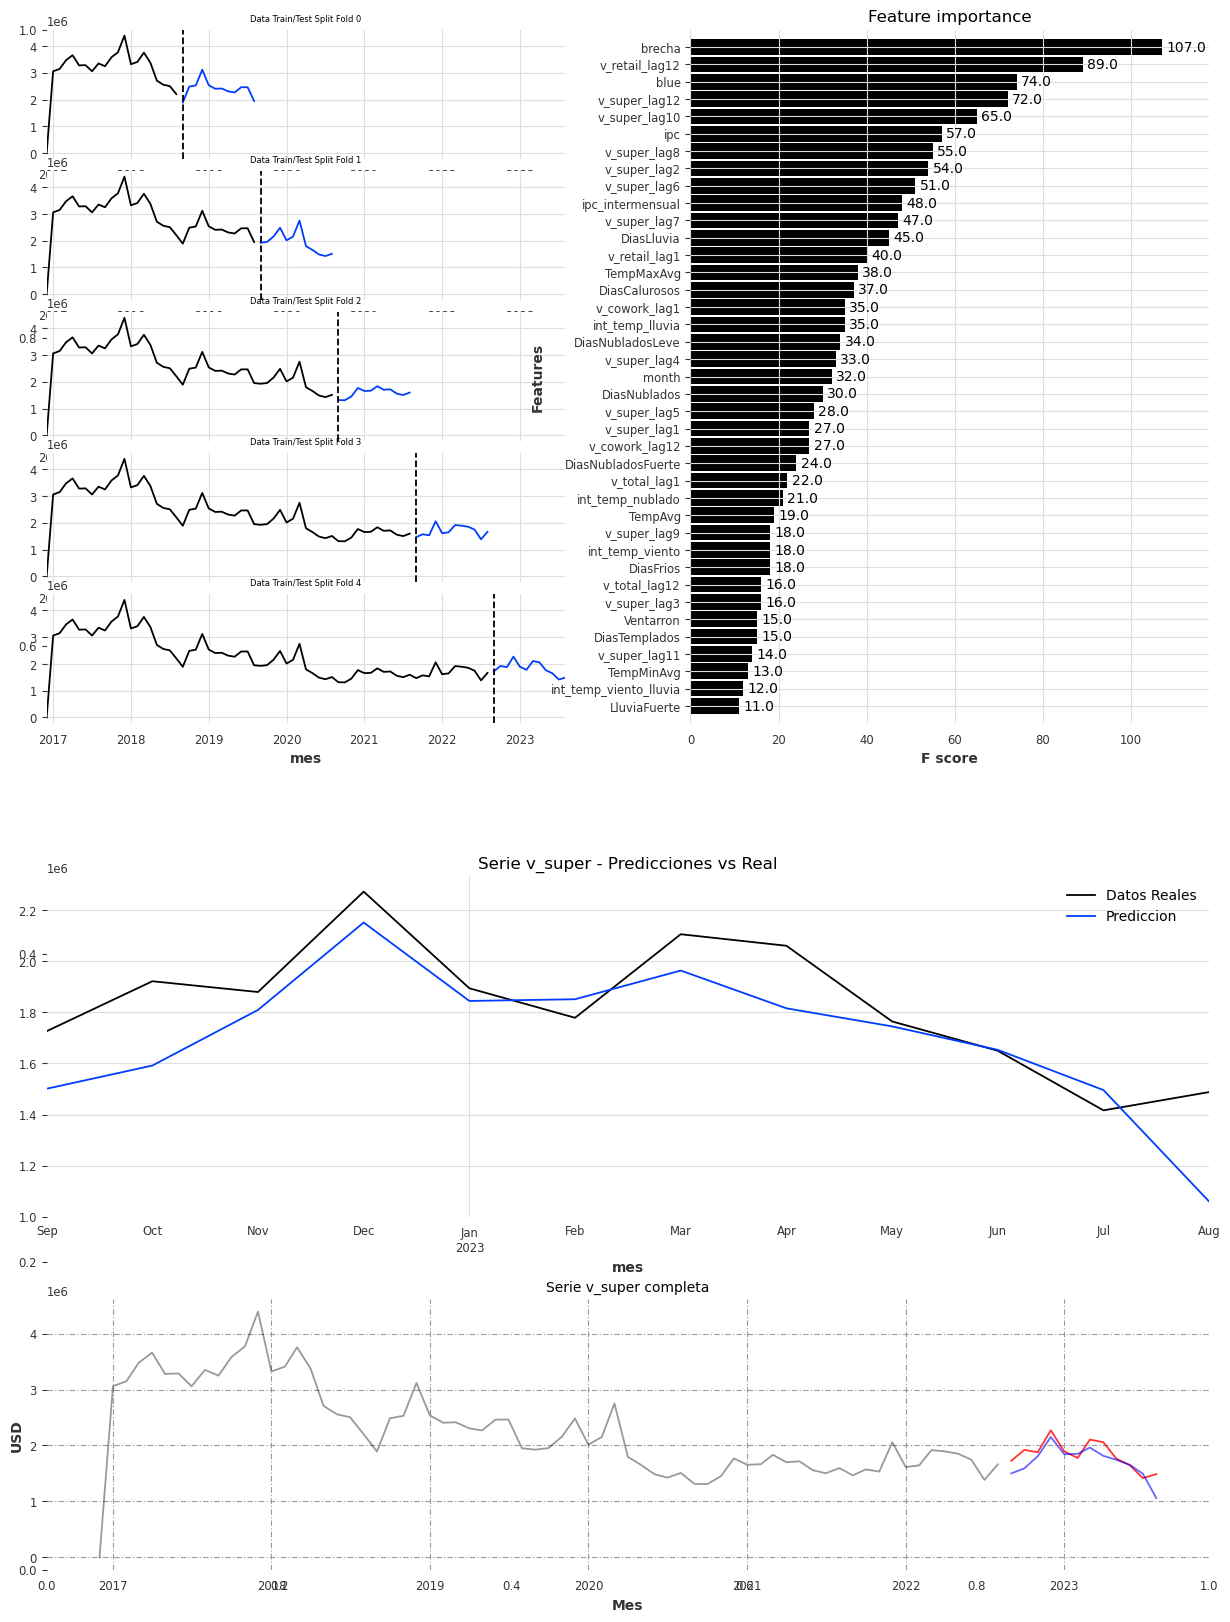

In [18]:
fig = predecir_xgboost(df,'v_super', iter = 500, learn_rate = 0.3, depth=2)

[0]	validation_0-rmse:3309281.28508	validation_0-mae:3122932.28214	validation_0-mape:inf	validation_1-rmse:2337319.47217	validation_1-mae:2129811.83333	validation_1-mape:0.64280
[499]	validation_0-rmse:0.84332	validation_0-mae:0.63912	validation_0-mape:inf	validation_1-rmse:1834937.30333	validation_1-mae:1108466.08333	validation_1-mape:0.32145
[0]	validation_0-rmse:3009267.37238	validation_0-mae:2831549.92197	validation_0-mape:inf	validation_1-rmse:1494786.22664	validation_1-mae:1260200.42708	validation_1-mape:0.84208
[499]	validation_0-rmse:0.89865	validation_0-mae:0.71931	validation_0-mape:inf	validation_1-rmse:1645312.96211	validation_1-mae:1361364.60417	validation_1-mape:1.85511
[0]	validation_0-rmse:2710884.74106	validation_0-mae:2441867.45000	validation_0-mape:inf	validation_1-rmse:1792100.44671	validation_1-mae:1716039.76042	validation_1-mape:0.78487
[499]	validation_0-rmse:0.61872	validation_0-mae:0.46179	validation_0-mape:inf	validation_1-rmse:831412.35448	validation_1-mae:741

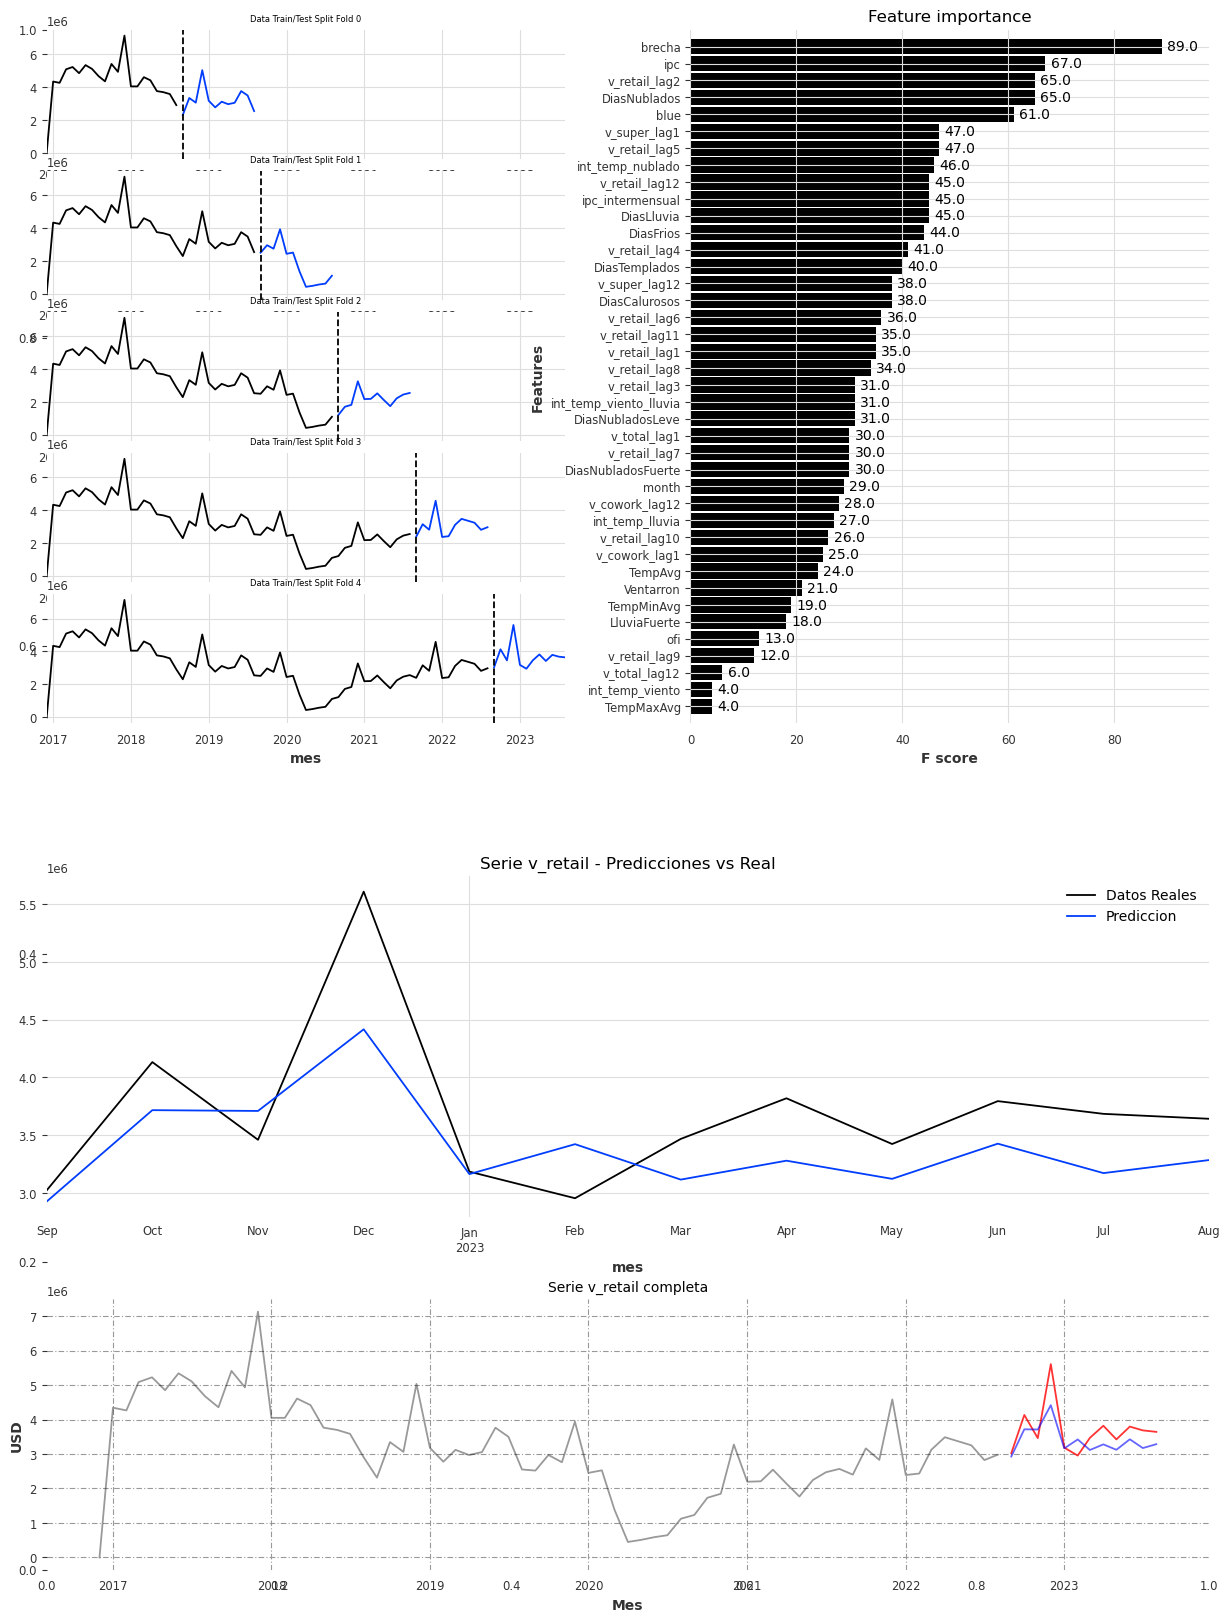

In [19]:
fig = predecir_xgboost(df,'v_retail', iter = 500, learn_rate = 0.3, depth=2)

[0]	validation_0-rmse:0.35682	validation_0-mae:0.35682	validation_0-mape:inf	validation_1-rmse:30303.09322	validation_1-mae:23683.67916	validation_1-mape:inf
[499]	validation_0-rmse:0.00000	validation_0-mae:0.00000	validation_0-mape:inf	validation_1-rmse:30303.37174	validation_1-mae:23683.79785	validation_1-mape:inf
[0]	validation_0-rmse:13874.44271	validation_0-mae:6315.85984	validation_0-mape:inf	validation_1-rmse:17374.70138	validation_1-mae:14893.13708	validation_1-mape:13.13179
[499]	validation_0-rmse:0.00611	validation_0-mae:0.00453	validation_0-mape:inf	validation_1-rmse:23170.82848	validation_1-mae:18053.91553	validation_1-mape:45.62115
[0]	validation_0-rmse:14887.10207	validation_0-mae:8465.45194	validation_0-mape:inf	validation_1-rmse:8465.06902	validation_1-mae:7718.80558	validation_1-mape:0.81268
[499]	validation_0-rmse:0.00634	validation_0-mae:0.00445	validation_0-mape:inf	validation_1-rmse:6985.62461	validation_1-mae:6001.96525	validation_1-mape:0.54434
[0]	validation_0-r

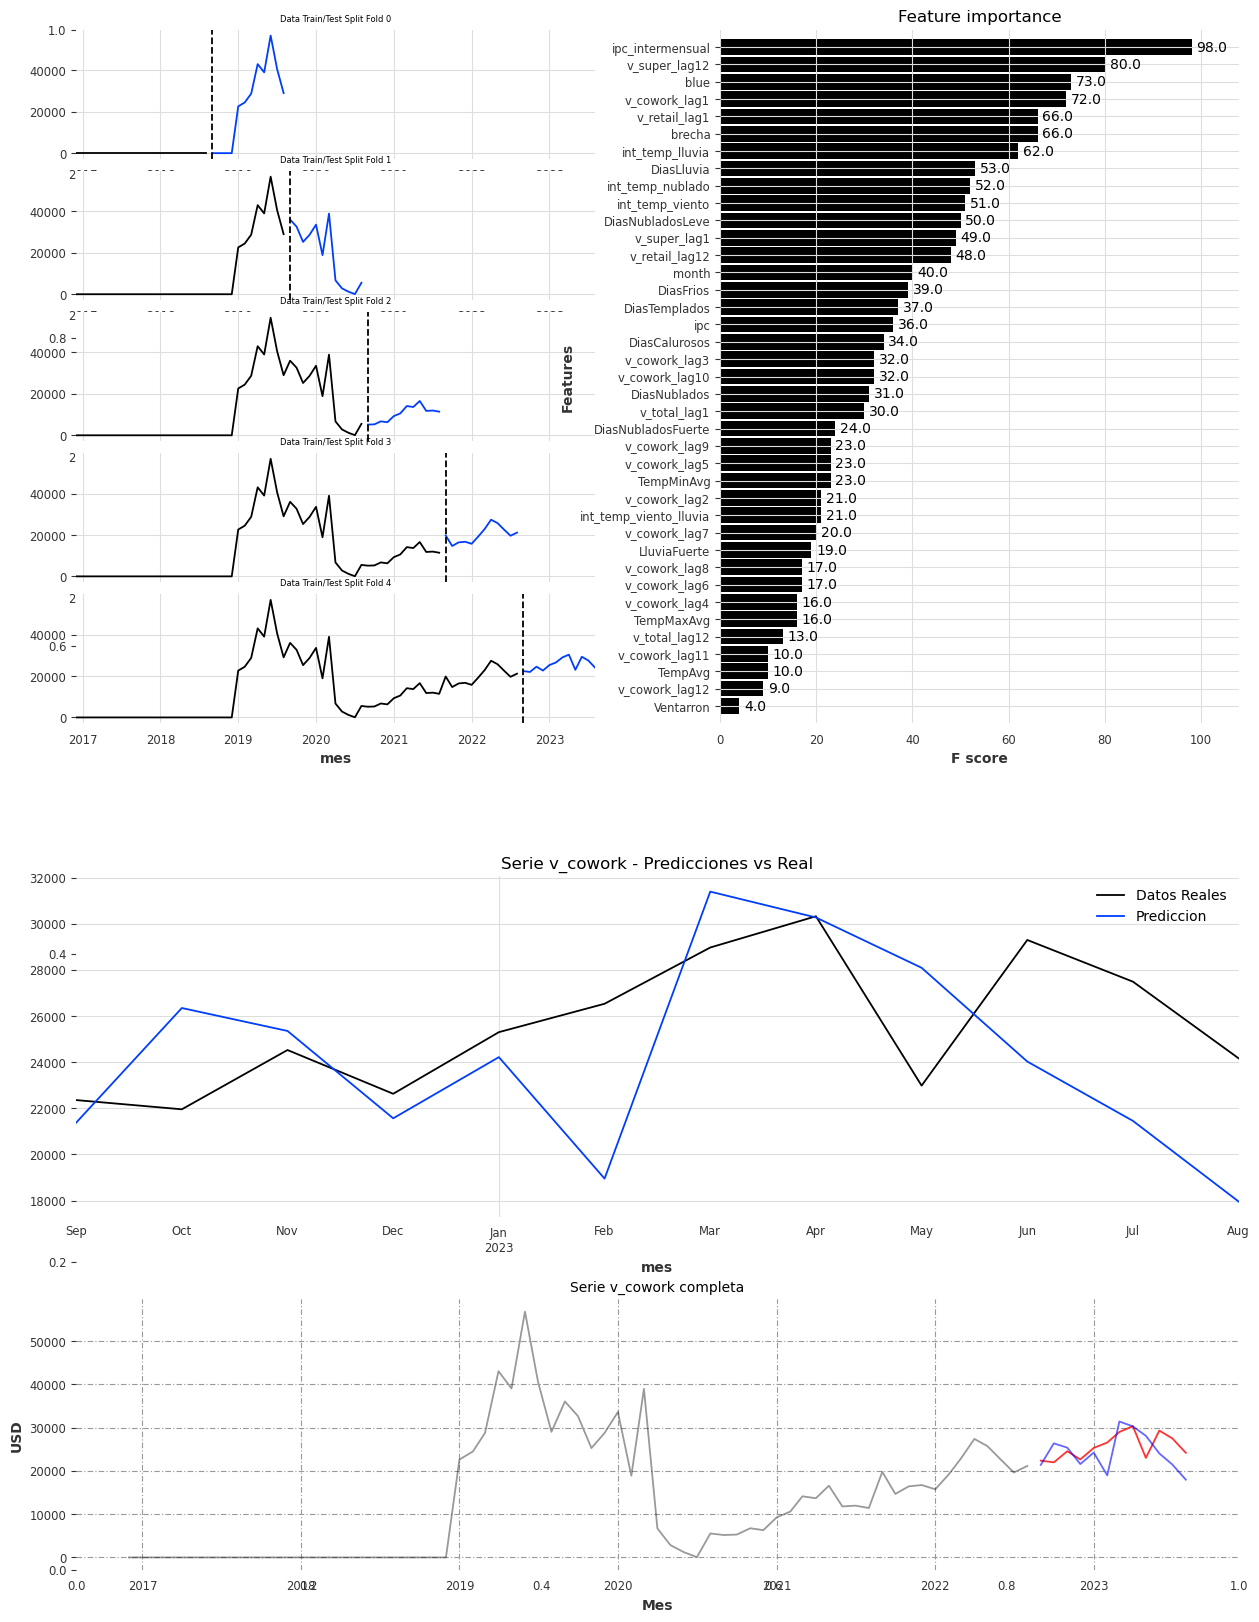

In [20]:
fig = predecir_xgboost(df,'v_cowork', iter = 500, learn_rate = 0.3, depth=2)